# Import Libraries

In [15]:
import os
from glob import glob
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Creating Tissue, Mask and Negative WSI List

## Paths

In [2]:
home_dir = "/Users/mah_prince/Thesis/Azam Sir/Colon Cancer/Code/test_tf_project/Colonoscopy_tissue_segment_dataset"
neg_dir = os.path.join(home_dir, "tissue-train-neg")
pos_dir = os.path.join(home_dir, "tissue-train-pos-v1")

## Creating Negative List

In [3]:
neg_wsi_list = glob(neg_dir + "/*")
print(f"Images in Negative Folder: {len(neg_wsi_list)}")

Images in Negative Folder: 410


## Creating Mask and Tissue list

In [4]:
substring = '_mask.jpg'
masks_wsi_list = glob(os.path.join(pos_dir, f'*{substring}')) # getting only the mask files 
tissue_wsi_list = list(set(glob(pos_dir + "/*")) - set(masks_wsi_list)) #excluding masks from all positive files

print(f"Positive Folder / Mask: {len(masks_wsi_list)}")
print(f"Positive Folder / Tissue: {len(tissue_wsi_list)}")

Positive Folder / Mask: 250
Positive Folder / Tissue: 250


# Sort Lists and Verify

18-00530B_2019-05-07 23_56_22-lv1-11712-16122-7372-7686.jpg
18-00530B_2019-05-07 23_56_22-lv1-11712-16122-7372-7686_mask.jpg

18-01080B_2019-05-07 21_33_52-lv1-11930-21381-3264-4008.jpg
18-01080B_2019-05-07 21_33_52-lv1-11930-21381-3264-4008_mask.jpg

18-01080B_2019-05-07 21_33_52-lv1-15262-19621-5715-4803.jpg
18-01080B_2019-05-07 21_33_52-lv1-15262-19621-5715-4803_mask.jpg
(7686, 7372, 3)
(7686, 7372, 3)


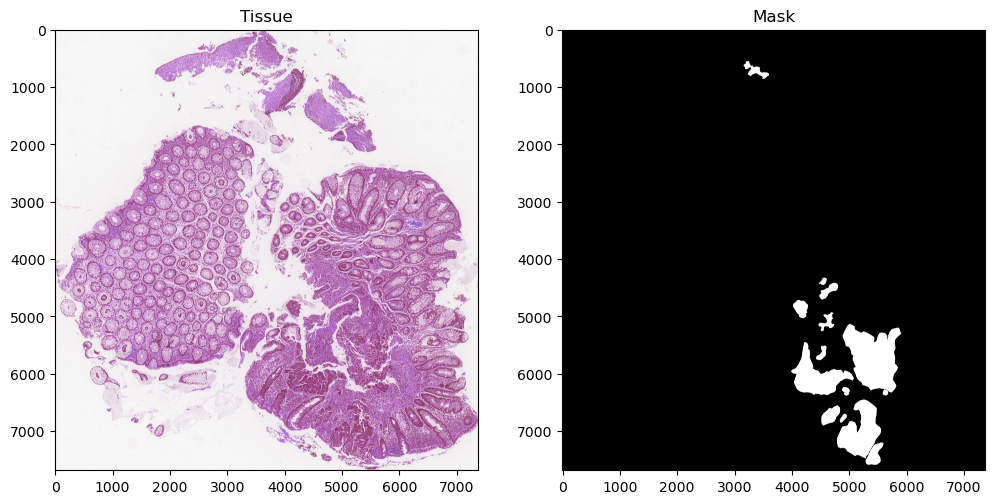

In [5]:
# By sorting the lists we can patchify simultaneously both on image and its mask
tissue_wsi_list = sorted(tissue_wsi_list)
masks_wsi_list = sorted(masks_wsi_list)

#Verify (tissue, mask) file name
print(os.path.basename(tissue_wsi_list[0]))
print(os.path.basename(masks_wsi_list[0]) +"\n")
print(os.path.basename(tissue_wsi_list[1]))
print(os.path.basename(masks_wsi_list[1]) +"\n")
print(os.path.basename(tissue_wsi_list[2]))
print(os.path.basename(masks_wsi_list[2]))

tissue_img = cv2.imread(tissue_wsi_list[0])
tissue_img = cv2.cvtColor(tissue_img, cv2.COLOR_BGR2RGB)

mask_img = cv2.imread(masks_wsi_list[0])
mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB)

#Verify (tissue, mask) shape
print(tissue_img.shape)
print(mask_img.shape)


#Plot (tissue, mask) side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image on the left subplot
axes[0].imshow(cv2.cvtColor(tissue_img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Tissue')

# Plot the second image on the right subplot
axes[1].imshow(cv2.cvtColor(mask_img, cv2.COLOR_BGR2RGB))
axes[1].set_title('Mask')
plt.show()

# WSI to Patches

## Function to Extract Patch from WSI 

In [6]:
def wsi_to_patch(wsi_path):
    """
    :param wsi_path: Path of the WSI to extract patch
    :return: list of extracted patches of type <class 'tensorflow.python.framework.ops.EagerTensor'>
            Can be converted to numpy ndarray if any operation on the patch is not working correctly
    """
    
    image = cv2.imread(wsi_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Define patch size and stride
    patch_size = [512, 512]  # Specify the size of each patch (height x width)
    # We are using non-overlapping patch
    stride = [512, 512]  # Specify the stride for patch extraction (height x width)
    
    # Use tf.image.extract_patches to extract patches
    patches = tf.image.extract_patches(
        images=tf.expand_dims(image, axis=0),  # Add a batch dimension
        sizes=[1, *patch_size, 1],  # Add batch and channel dimensions
        strides=[1, *stride, 1],  # Add batch and channel dimensions
        rates=[1, 1, 1, 1],  # Default rates
        padding='VALID'  # Use 'VALID' padding to ensure no padding is added
    )
    
    # Reshape the extracted patches
    num_patches = patches.shape[1] * patches.shape[2]
    
    patches = tf.reshape(patches, [num_patches, *patch_size, 3])  # Assuming 3 channels for RGB images
    
    # Now, 'patches' contains the extracted patches
    print (f"{os.path.basename(wsi_path)} shape: {patches.shape}")
    # print("Shape of each patch:", patches.shape)
    
    return patches

## Function to Write Patch to Disk

In [7]:
def write_patch(patches, img_path, write_path):
    """
    :param patches: a list of patches 
    :param img_path: the path of the patch
    :param write_path: the path to write the single patch
    :return: void
    """
    #Getting WSI file name
    wsi_file_name = os.path.basename(img_path)
    wsi_file_name = os.path.splitext(wsi_file_name)[0]
    
    #Writing patch in write_path
    no_of_patches = 0
    for patch in patches:
        no_of_patches = no_of_patches+1
        patch_file_name = (wsi_file_name + "_Patch_"+str(no_of_patches) + ".jpg")
        #patch is of type <class 'tensorflow.python.framework.ops.EagerTensor'> so converting to numpy ndarray
        cv2.imwrite(os.path.join(write_path, patch_file_name), patch.numpy())
    
    print(f"Patch written: {no_of_patches} from WSI: {wsi_file_name}")
    
    return no_of_patches

## Patchify

## Neg WSI to Patch

In [12]:
# neg_patch_path = "/Users/mah_prince/Thesis/Azam Sir/Colon Cancer/Code/test_tf_project/Colonoscopy_tissue_segment_dataset/neg_patch"
# total_patch = 0
# 
# for img_path in neg_wsi_list:
#     neg_patches = wsi_to_patch(img_path)
#     total_patch += write_patch(neg_patches, img_path, neg_patch_path)
# 
# print(f"Total Patch: {total_patch}")

2023-09-11 13:17:52.832047: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-11 13:17:52.832525: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-11 13:17:52.832963: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-11 13:17:52.833831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-11 13:17:52.835343: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2019-07501-1-1-1_2019-05-29 08_22_25-lv1-8582-14509-4265-3814.jpg shape: (56, 512, 512, 3)
Patch written: 56 from WSI: 2019-07501-1-1-1_2019-05-29 08_22_25-lv1-8582-14509-4265-3814
2019-07506-1-1-1_2019-05-29 06_34_07-lv1-31721-10829-5554-3640.jpg shape: (70, 512, 512, 3)
Patch written: 70 from WSI: 2019-07506-1-1-1_2019-05-29 06_34_07-lv1-31721-10829-5554-3640
D20190284705_2019-06-10 15_10_34-lv1-15598-12648-5733-5319.jpg shape: (110, 512, 512, 3)
Patch written: 110 from WSI: D20190284705_2019-06-10 15_10_34-lv1-15598-12648-5733-5319
1902160001_2019-06-11 12_36_32-lv1-39045-16016-3312-4096.jpg shape: (48, 512, 512, 3)
Patch written: 48 from WSI: 1902160001_2019-06-11 12_36_32-lv1-39045-16016-3312-4096
2019-07503-1-1-1_2019-05-29 06_57_56-lv1-44861-7903-3113-957.jpg shape: (6, 512, 512, 3)
Patch written: 6 from WSI: 2019-07503-1-1-1_2019-05-29 06_57_56-lv1-44861-7903-3113-957
2019-10965-1-1-1_2019-05-28 15_12_46-lv1-41393-10795-4607-7564.jpg shape: (112, 512, 512, 3)
Patch written: 112

## Tissue WSI to Patch

In [13]:
# tissue_patch_path = "/Users/mah_prince/Thesis/Azam Sir/Colon Cancer/Code/test_tf_project/Colonoscopy_tissue_segment_dataset/pos_tissue_patch"
# total_patch = 0
# 
# for img_path in tissue_wsi_list:
#     tissue_patches = wsi_to_patch(img_path)
#     total_patch += write_patch(tissue_patches, img_path, tissue_patch_path)
# print(f"Total Patch: {total_patch}")

18-00530B_2019-05-07 23_56_22-lv1-11712-16122-7372-7686.jpg shape: (210, 512, 512, 3)
Patch written: 210 from WSI: 18-00530B_2019-05-07 23_56_22-lv1-11712-16122-7372-7686
18-01080B_2019-05-07 21_33_52-lv1-11930-21381-3264-4008.jpg shape: (42, 512, 512, 3)
Patch written: 42 from WSI: 18-01080B_2019-05-07 21_33_52-lv1-11930-21381-3264-4008
18-01080B_2019-05-07 21_33_52-lv1-15262-19621-5715-4803.jpg shape: (99, 512, 512, 3)
Patch written: 99 from WSI: 18-01080B_2019-05-07 21_33_52-lv1-15262-19621-5715-4803
18-01454B_2019-05-07 21_53_08-lv1-11459-21716-5502-4209.jpg shape: (80, 512, 512, 3)
Patch written: 80 from WSI: 18-01454B_2019-05-07 21_53_08-lv1-11459-21716-5502-4209
18-01454B_2019-05-07 21_53_08-lv1-12943-25586-5481-2968.jpg shape: (50, 512, 512, 3)
Patch written: 50 from WSI: 18-01454B_2019-05-07 21_53_08-lv1-12943-25586-5481-2968
18-01592A_2019-05-07 21_59_18-lv1-18492-12001-4720-3984.jpg shape: (63, 512, 512, 3)
Patch written: 63 from WSI: 18-01592A_2019-05-07 21_59_18-lv1-18492-

## Mask WSI to Patch

In [14]:
# mask_patch_path = "/Users/mah_prince/Thesis/Azam Sir/Colon Cancer/Code/test_tf_project/Colonoscopy_tissue_segment_dataset/pos_mask_patch"
# total_patch = 0
# for img_path in masks_wsi_list:
#     mask_patches = wsi_to_patch(img_path)
#     total_patch += write_patch(mask_patches, img_path, mask_patch_path)
# 
# print(f"Total Patch: {total_patch}")

18-00530B_2019-05-07 23_56_22-lv1-11712-16122-7372-7686_mask.jpg shape: (210, 512, 512, 3)
Patch written: 210 from WSI: 18-00530B_2019-05-07 23_56_22-lv1-11712-16122-7372-7686_mask
18-01080B_2019-05-07 21_33_52-lv1-11930-21381-3264-4008_mask.jpg shape: (42, 512, 512, 3)
Patch written: 42 from WSI: 18-01080B_2019-05-07 21_33_52-lv1-11930-21381-3264-4008_mask
18-01080B_2019-05-07 21_33_52-lv1-15262-19621-5715-4803_mask.jpg shape: (99, 512, 512, 3)
Patch written: 99 from WSI: 18-01080B_2019-05-07 21_33_52-lv1-15262-19621-5715-4803_mask
18-01454B_2019-05-07 21_53_08-lv1-11459-21716-5502-4209_mask.jpg shape: (80, 512, 512, 3)
Patch written: 80 from WSI: 18-01454B_2019-05-07 21_53_08-lv1-11459-21716-5502-4209_mask
18-01454B_2019-05-07 21_53_08-lv1-12943-25586-5481-2968_mask.jpg shape: (50, 512, 512, 3)
Patch written: 50 from WSI: 18-01454B_2019-05-07 21_53_08-lv1-12943-25586-5481-2968_mask
18-01592A_2019-05-07 21_59_18-lv1-18492-12001-4720-3984_mask.jpg shape: (63, 512, 512, 3)
Patch written

# Create Negative Mask Patch

## Function to Create Mask Patch

In [31]:
neg_patch_path = "/Users/mah_prince/Thesis/Azam Sir/Colon Cancer/Code/test_tf_project/Colonoscopy_tissue_segment_dataset/neg_patch"
write_path = "/Users/mah_prince/Thesis/Azam Sir/Colon Cancer/Code/test_tf_project/Colonoscopy_tissue_segment_dataset/neg_mask_patch"

def create_neg_mask_patch(neg_patch_path, write_path):
    neg_patches_path_list = sorted(glob(neg_patch_path+"/*"))
    insert_substring = "mask_Patch"
    count = 0
    
    for neg_patch in neg_patches_path_list:
        input_file_name = os.path.basename(neg_patch)
        new_file_name = input_file_name.replace("Patch", insert_substring)
        print(new_file_name)

        neg_patch_img = cv2.imread(neg_patch)
        neg_mask_patch = np.zeros_like(neg_patch_img)

        #Write the patch
        patch_file_name = new_file_name
        # patch is of type <class 'tensorflow.python.framework.ops.EagerTensor'> so converting to numpy ndarray
        cv2.imwrite(os.path.join(write_path, patch_file_name), neg_mask_patch)
        count += 1

    print(f"Written {count} negative mask patch")


#Call function
create_neg_mask_patch(neg_patch_path, write_path)

1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_1.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_10.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_11.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_12.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_13.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_14.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_15.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_16.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_17.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_18.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_19.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_2.jpg
1800769002_2019-06-11 13_32_47-lv1-36878-15878-2411-4096_mask_Patch_20.jpg
1800769002_2019-06-11 13_32